# 10. Syntax — Lab exercises

## Preparations

### Introduction

In this lab, we are going to use the [Python Natural Language Toolkit](http://www.nltk.org/) (`nltk`). It has an API that allows you to create, read, and parse with Context-free Grammars (CFG), as well as to convert parse trees to Chomsky Normal Form (CNF) and back and to display or pretty print them.

During the first few exercises, we are going to acquint ourselves with nltk using a toy grammar. In the second part, you will be asked to implement the CKY algorithm and test it on a real world treebank.

### Infrastructure

For today's exercises, you will need the docker image again. Provided you have already downloaded it last time, you can start it by:

- `docker ps -a`: lists all the containers you have created. Pick the one you used last time (with any luck, there is only one)
- `docker start <container id>`
- `docker exec -it <container id> bash`

In order to be able to run today's exercises, you will have to install some system- and Python packages as well:

```bash
apt-get install python3-tk
pip install graphviz
```

When that's done, update your git repository:

```bash
cd /nlp/python_nlp_2017_fall/
git pull
```

And start the notebook:
```
jupyter notebook --port=9999 --ip=0.0.0.0 --no-browser --allow-root
```

### Boilerplate

The following code imports the packages we are going to use. It also defines a function that draws the parse trees with the [`Graphviz`](http://www.graphviz.org/) library. `nltk` _can_ display the trees, but it depends on Tcl, which doesn't work on a headless (GUI-less) system.

In [7]:
import graphviz
import nltk
from nltk import Nonterminal
from nltk.parse.generate import generate
from nltk.tree import Tree

def does_tcl_work():
    """Checks if Tcl is installed and works (e.g. it won't on a headless server)."""
    tree = nltk.tree.Tree('test', [])
    try:
        tree._repr_png_()
        return True
    except:
        return False

def draw_tree(tree):
    """Draws an NLTK parse tree via Graphviz."""
    def draw_tree_rec(curr_root, graph, last_node):
        node_id = str(int(last_node) + 1)
        for child in curr_root:
            if isinstance(child, nltk.tree.Tree):
                graph.node(node_id, child.label(), penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = draw_tree_rec(child, graph, node_id)
            else:
                graph.node(node_id, child, penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = str(int(node_id) + 1)
        return str(int(node_id) + 1)
    
    graph = graphviz.Graph()
    graph.graph_attr['ranksep'] = '0.2'
    graph.node('0', tree.label(), penwidth='0')
    draw_tree_rec(tree, graph, '0')
    return graph._repr_svg_()

# Use Graphviz to draw the tree if the Tcl backend of nltk doesn't work
if not does_tcl_work():
    svg_formatter = get_ipython().display_formatter.formatters['image/svg+xml']
    svg_formatter.for_type(nltk.tree.Tree, draw_tree)
    # Delete the nltk drawing function, just to be sure
    delattr(Tree, '_repr_png_')

### Disclaimer

NLTK is not the only NLP library for Python. [spaCy] is "industrial-strength" library which, like NLTK, implements various NLP tools for multiple languages. However, it also supports neural network models (on the GPU as well) and it integrates word vectors. A comparison is [availabe here](https://spacy.io/usage/facts-figures). We teach NLTK in this course because
1. it lends itself better to education and experimentation
1. of [certain](https://www.usatoday.com/story/life/2017/11/07/kevin-spacey-scandal-complete-list-13-accusers/835739001/) [scandals](http://index.hu/kultur/cinematrix/2017/11/03/kevin_spacey_karrierjenek_igencsak_lottek/)

However, if you are doing serious NLP work, you should also consider spaCy.

## Exercises

### 1. Get to know nltk

In this exercise, we are using the toy grammar from the lecture with a little modification so that it can handle ditransitives.

In [ ]:
# fromstring() returns a CFG instance from a string
# Observe the two ways one can specify alternations in the grammar
# and how terminal symbols are specified
toy_grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pronoun | ProperNoun | Det Nominal
Nominal -> Nominal Noun
Nominal -> Noun
VP -> Verb | Verb PP | Verb NP | Verb NP PP | Verb NP NP | Verb NP NP PP
PP -> Preposition NP
Pronoun -> 'he' | 'she' | 'him' | 'her'
ProperNoun -> 'John' | 'Mary' | 'Fido'
Det -> 'a' | 'an' | 'the'
Noun -> 'flower' | 'bone' | 'necklace' | 'dream' | 'hole' | 'café' | 'house' | 'bed'
Verb -> 'loves' | 'gives' | 'gave' | 'sleeps' | 'digs' | 'dag' | 'ate'
Preposition -> 'in' | 'on' | 'behind'
""")

In [ ]:
# Now for some properties:

print('Max RHS length:', toy_grammar.max_len())
print('The start symbol is', toy_grammar.start())
print('Is it in CNF:', toy_grammar.is_chomsky_normal_form())
print('Is this a lexical grammar:', toy_grammar.is_lexical())
print('All productions:', toy_grammar.productions())

In [ ]:
# Let's generate a few sentences
for sentence in generate(toy_grammar, n=10):
    print(' '.join(sentence))

Unfortunately, `generate()` only generates the sentences in order. Also, it can run into problems with recursive grammars. Here is a version that generates random sentences.

In [ ]:
import random
from itertools import count

def generate_sample(grammar, start=None):
    """Generates a single sentence randomly."""
    gen = [start or grammar.start()]
    curr_p = 0
    while curr_p < len(gen):
        production = random.choice(grammar.productions(lhs=gen[curr_p]))
        if production.is_lexical():
            gen[curr_p] = production.rhs()[0]
            curr_p += 1
        else:
            gen = gen[:curr_p] + list(production.rhs()) + gen[curr_p + 1:]
    return ' '.join(gen)

def generate_random(grammar, start=None, n=None):
    """Generates sentences randomly."""
    for i in count(0):
        yield generate_sample(grammar, start)
        if i == n:
            break

for sentence in generate_random(toy_grammar, n=10):
    print(sentence)

Sentences can also be parsed:

In [ ]:
toy_parser = nltk.ChartParser(toy_grammar)
# the split() part is important
for tree in toy_parser.parse('John gave Mary a flower in the café'.split()):
    display(tree)

The parse returns an iterator of `nltk.tree.Tree` objects. This class has some useful functions, such as

In [ ]:
# Converts the tree to CNF
tree.chomsky_normal_form()
display(tree)
# Let's convert it back...
tree.un_chomsky_normal_form()
print('The tree has', len(tree), 'children.')
print('The first child is another tree:', tree[0])
print('All nonterminals are Trees. They have labels:', tree[1].label())
print('Terminals are just strings:', tree[0][0][0])

Note that in `nltk`, one can convert a `Tree` to CNF, but not the whole grammar. `nltk` has some strange design choices - the other being their reliance on Tcl. If you run this notebook on your own machine, a nifty grammar editing tool will pop up if you run

In [ ]:
# nltk.app.rdparser()
# nice!

### 2. Arithmetics

#### 2.1 Basics
Model the four elementary mathematical operations, namely `+`, `-`, `*` and `/`. Your tasks is to validate mathematical expressions that use them. Specifically:
- single-digit numbers are valid expressions
- if `expr1` and `expr2` are valid expressions, these are also valid:
  - `expr1 + expr2`
  - `expr1 - expr2`
  - `expr1 * expr2`
  - `expr1 / expr2`
  - `(expr1)`
  
Try to solve it with as few nonterminals as possible.

In [ ]:
# Your solution here
agr = nltk.CFG.fromstring("""
S -> expr
expr -> '(' expr ')' | expr op expr | num
num -> '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
op -> '+' | '-' | '*' | '/'
""")
aparser = nltk.ChartParser(agr)

# Test
for tree in aparser.parse('1 - 2 / ( 3 - 4 )'.split()):
    display(tree)

#### 2.2 Precedence

If you implemented the previous task with a single nonterminal, you will see that the grammar is undeterministic, and some parses do not reflect the precedence of mathematical operators. Fix the grammar so that it does!

Hints:
- `+` and `-` should be higher up the tree than `*` and `/`
- you will need at least 3 nonterminals
- allow chaining of the same operator types, e.g. `1 + 2 - 3`. One of the nonterminals in the toy grammar above does something similar
- do not worry about unit productions, but don't create a unit recursion cycle (e.g. `A -> B -> C -> A`)

In [ ]:
# Your solution here
agr = nltk.CFG.fromstring("""
S -> expr
expr -> paropen expr parclose | mulexpr add expr | expr add mulexpr | mulexpr add mulexpr | expr add expr | num
mulexpr -> expr mul expr | expr mul mulexpr | mulexpr mul mulexpr
num -> '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
add -> '+' | '-' 
mul -> '*' | '/'
paropen -> '('
parclose -> ')'
""")
aparser = nltk.ChartParser(agr)

# Test
for tree in aparser.parse('1 + 2 / ( 3 * ( 3 - 4 + 9 ) - 2 )'.split()):
    display(tree)

assert len(list(aparser.parse('1 - 2 + 3 / ( 4 - 5 )'.split()))) > 0

#### 2.3 CNF

Parse an expression and convert the resulting tree into CNF. If you succeed, congratulations, you can skip this exercise.

However, most likely the function will throw an exception. This is because the NLTK algorithm cannot cope with rules that mix nonterminals and terminals in certain ways (e.g. `A -> B '+' C`). Fix your grammar by introducing a POS-like nonterminal (e.g. `add` for `+`) into each such rule.

In [ ]:
# Your solution here

# Test
tree = list(aparser.parse('1 - 2 / ( 3 - 4 )'.split()))[0]
tree.chomsky_normal_form()
display(tree)

#### 2.4 Evaluation*

Compute the value of the expression. Implement a recursive function that traverses the tree and returns an interger.

Note: if you implemented this function well, but get an `AssertionError` from the last line, it means that your grammar is probably right associative. Look at the (non-CNF) tree to confirm this. If so, make it left associative.

In [ ]:
def evaluate_tree(tree):
    """Returns the value of the expression represented by tree."""
    return eval(''.join(tree.leaves()))
    
    

# Test
assert evaluate_tree(next(aparser.parse('1+(2+0)'))) == 3
assert evaluate_tree(next(aparser.parse('1+2*3'))) == 7
assert evaluate_tree(next(aparser.parse('3/(2-3)-4/2-5'))) == -10

### 3. CKY

Up until now, we used NLTK's `ChartParser` to parse our grammar. In this exercise, we will replace it with our own implementation of CKY.

#### 3.1 The parser class

First, create the `CKYParser` class. Imitate the interface of `ChartParser`. You don't need to look up the API: support only the functions we used thus far.

In [8]:
import numpy as np


class CKYParser(object):
    def __init__(self, grammar):
        if not isinstance(grammar, nltk.CFG):
            raise TypeError("g")
        self.grammar = grammar
    
    def parse(self, sent):
        n = len(sent)
        # init
        cky = np.empty((n,n), dtype=object)
        for i in range(n):
            for j in range(n):
                cky[i, j] = []
        # lexical rules
        for i, word in enumerate(sent):
            for prod in self.grammar.productions():
                if word in prod.rhs():
                    cky[i, i].append(prod.lhs().symbol())
        # rules
        for col in range(1, n):
            for row in range(col-1, -1, -1):
                ways_to_split = col-row  # "distance" from diag
                for w in range(ways_to_split):
                    left = ways_to_split - w
                    down = 1 + w
                    for prod in self.grammar.productions():
                        if len(prod.rhs()) < 2:
                            continue
                        ls = prod.rhs()[0].symbol()  # left symbol
                        ds = prod.rhs()[1].symbol()  # down symbol
                        if ls in cky[row, col-left] and ds in cky[row+down, col]:
                            cky[row, col].append(prod.lhs().symbol())
        if 'S' in cky[0, n-1]:
            return True
        return False
                
    
    

#### 3.2 Implement `parse()`

Implement the `parse()` method. You don't need to worry about the backpointers for now; just treat the cells of the matrix as a piece of paper and write strings to them. The functions should just return `True` if the sentence is grammatical and `False` if it isn't.

Hints:
- the easiest format for the matrix is probably a 2D `numpy` array with a `list` in each cell (we might have multiple candidates in a cell). Use `dtype=object`. Don't forget to initialize it.
- the `display()` method works on arrays and is a useful tool for debugging
- in 2D `numpy` arrays, rows are numbered from top to bottom. That takes care of the cell indexing part, because a cell represents the words `sentence[row:col+1]`.
- Implement just the main diagonal (lexical rules) first.
- Use the `grammar.productions()` function to get the list of production rules. To see how to use it, refer to
  - the `generate_sample` function above
  - `help(grammar.productions)`
- Note that in the production rules returned by `grammar.productions()`, terminals will be strings, and nonterminals instances of the `Nonterminal` object. You can get the actual symbol out of the latter with the `symbol()` method.

Use the CNF grammar below for development and the example sentence for testing.

In [9]:
# Test
grammar = nltk.CFG.fromstring("""
S -> NP VP | ProperNoun VP | NP Verb | ProperNoun Verb
NP -> Det Nominal | Det Noun
Nominal -> Nominal Noun | Noun Noun
VP -> Verb NP | Verb ProperNoun
Det -> 'the'
Noun -> 'dog' | 'bit'
ProperNoun -> 'John'
Verb -> 'bit'
""")

parser = CKYParser(grammar)
print('Sentence is grammatical:', parser.parse('the dog bit John'.split()))

Sentence is grammatical: True


#### 3.3 The full monty

Modify `parse()` so that it returns the parse tree. In the original CKY algorithm, each nonterminal maintains backpointers to its children. Instead, we will build the `Tree` object directly (which is little more that a label and a list of backpointers, really).

There are two things you should do here:
1. When filling a cell: instead of adding the name of the nonterminal to the list in the cell, add a `Tree` with the name as label and the right children. The constructor's signature is `Tree(node, children)`, where the latter is a `list`.
2. Change your method to be a _generator_: yield all `Tree`s from the top right cell whose label is `S`.

Don't forget that `Tree.label()`s are strings, so if you want to look for them in `grammar.productions()`, enclose them into a `Nonterminal` object.

In [21]:
import nltk
import numpy as np
from nltk.tree import Tree


class CKYParser(object):
    def __init__(self, grammar):
        if not isinstance(grammar, nltk.CFG):
            raise TypeError("g")
        self.grammar = grammar
    
    def parse(self, sent):
        n = len(sent)
        # init
        cky = np.empty((n,n), dtype=object)
        for i in range(n):
            for j in range(n):
                cky[i, j] = []
        # lexical rules
        for i, word in enumerate(sent):
            for prod in self.grammar.productions():
                if word in prod.rhs():
                    cky[i, i].append(Tree(prod.lhs(), [word]))
        # rules
        for col in range(1, n):
            for row in range(col-1, -1, -1):
                ways_to_split = col-row  # "distance" from diag
                for w in range(ways_to_split):
                    left = ways_to_split - w
                    down = 1 + w
                    for prod in self.grammar.productions():
                        if len(prod.rhs()) < 2:
                            continue
                        ls = prod.rhs()[0]  # left symbol
                        ds = prod.rhs()[1]  # down symbol
                        for lt in cky[row, col-left]:
                            for dt in cky[row+down, col]:
                                if lt.label() == ls and dt.label() == ds:
                                    cky[row, col].append(Tree(prod.lhs(), [lt, dt]))
        for tree in cky[0, n-1]:
            if tree.label() == nltk.Nonterminal('S'):
                yield tree

[Tree(S, [Tree(NP, [Tree(Det, ['the']), Tree(Noun, ['dog'])]), Tree(VP, [Tree(Verb, ['bit']), Tree(ProperNoun, ['John'])])])]
S
yielding tree


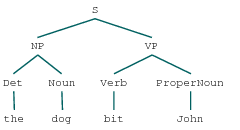

In [22]:

# Test
parser = CKYParser(grammar)
for tree in parser.parse('the dog bit John'.split()):
    display(tree)

### 4. Treebanks

NLTK also contains corpora. Amongst others, it contains about 10% of the Penn TreeBank (PTB).

#### 4.1 Download

Download the corpus with the `nltk.download()` tool. It is under Corpora and is called `treebank`.

In [ ]:
nltk.download()

#### 4.2 Corpus statistics

The functions below can be used to get the file ids, words, sentences, parse trees from the treebank.

Using them, get the following following corpus statistics:
- the number of sentences
- number of words

In [ ]:
from nltk.corpus import treebank

# PTB file ids
print('num sen:', len(treebank.sents()))

# Words in one of the files
print('num words:', len(treebank.words()))

# Word - POS-tag pairs
print('Tagged words:', treebank.tagged_words('wsj_0003.mrg'))

display(treebank.parsed_sents('wsj_0003.mrg')[0])

# Your solution here